In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def scrape_airbnb_listing(url, check_in_date=None, check_out_date=None):
    """
    Scrape an Airbnb listing and return the data as a DataFrame.
    
    Args:
        url (str): The URL of the Airbnb listing
        check_in_date (str, optional): Check-in date in format 'YYYY-MM-DD'
        check_out_date (str, optional): Check-out date in format 'YYYY-MM-DD'
        
    Returns:
        pandas.DataFrame: DataFrame containing the listing information
    """
    # Set up Firefox options
    firefox_options = Options()
    firefox_options.add_argument("--headless")  # Run in headless mode (no browser UI)
    firefox_options.add_argument("--no-sandbox")
    firefox_options.add_argument("--disable-dev-shm-usage")
    firefox_options.add_argument("--window-size=1920,1080")  # Set window size

    # Initialize the Firefox driver
    driver = webdriver.Firefox(options=firefox_options)
    
    # Modify URL if dates are provided
    if check_in_date and check_out_date:
        if '?' in url:
            url += f"&check_in={check_in_date}&check_out={check_out_date}"
        else:
            url += f"?check_in={check_in_date}&check_out={check_out_date}"
    
    try:
        # Navigate to the URL
        #print(url)
        driver.get(url)

        # Wait longer for the page to load
        #print("Waiting for page to load...")
        time.sleep(2)

        # Create a dictionary to store listing data
        listing_data = {}
        
        # Get listing title
        try:
            title_element = driver.find_element(By.CSS_SELECTOR, "h1")
            listing_data['title'] = title_element.text
        except Exception as e:
            listing_data['title'] = "N/A"
        
        # Get price
        try:
            # Try multiple possible price selectors
            price_selectors = [
                "span._hb913q", 
                "span._tyxjp1",  # Adding this selector based on the image
                "span[data-testid='price-element']",
                "div._1k4xcdh span",  # Common price container
                "span._1k4xcdh",      # Direct span with class _1k4xcdh
                "div._1qs94rc span"   # Another common price container
            ]
            
            price_found = False
            for selector in price_selectors:
                try:
                    price_elements = driver.find_elements(By.CSS_SELECTOR, selector)
                    for element in price_elements:
                        if element.text and "$" in element.text:
                            listing_data['price'] = element.text
                            price_found = True
                            break
                    if price_found:
                        break
                except:
                    continue
                    
            if not price_found:
                # Last resort: look for any element containing a dollar sign
                elements = driver.find_elements(By.XPATH, "//*[contains(text(), '$')]")
                if elements:
                    listing_data['price'] = elements[0].text
                else:
                    listing_data['price'] = "N/A"
        except Exception as e:
            print(f"Error getting price: {e}")
            listing_data['price'] = "N/A"
        
        # Get bedrooms
        try:
            bedroom_element = driver.find_element(By.CSS_SELECTOR, "li.l7n4lsf:contains('bedroom')")
            listing_data['bedrooms'] = bedroom_element.text.strip()
        except Exception as e:
            try:
                # Alternative selector
                bedroom_elements = driver.find_elements(By.CSS_SELECTOR, "li.l7n4lsf")
                for element in bedroom_elements:
                    if "bedroom" in element.text:
                        listing_data['bedrooms'] = element.text.strip()
                        break
                else:
                    listing_data['bedrooms'] = "N/A"
            except:
                listing_data['bedrooms'] = "N/A"
        
        # Get beds
        try:
            bed_element = driver.find_element(By.CSS_SELECTOR, "li.l7n4lsf:contains('bed')")
            listing_data['beds'] = bed_element.text.strip()
        except Exception as e:
            try:
                # Alternative selector
                bed_elements = driver.find_elements(By.CSS_SELECTOR, "li.l7n4lsf")
                for element in bed_elements:
                    if "bed" in element.text and "bedroom" not in element.text:
                        listing_data['beds'] = element.text.strip()
                        break
                else:
                    listing_data['beds'] = "N/A"
            except:
                listing_data['beds'] = "N/A"
        
        # Get bathrooms
        try:
            bath_element = driver.find_element(By.CSS_SELECTOR, "li.l7n4lsf:contains('bath')")
            listing_data['bathrooms'] = bath_element.text.strip()
        except Exception as e:
            try:
                # Alternative selector
                bath_elements = driver.find_elements(By.CSS_SELECTOR, "li.l7n4lsf")
                for element in bath_elements:
                    if "bath" in element.text:
                        listing_data['bathrooms'] = element.text.strip()
                        break
                else:
                    listing_data['bathrooms'] = "N/A"
            except:
                listing_data['bathrooms'] = "N/A"
        
        # Add check-in and check-out dates to the data if provided
        if check_in_date:
            listing_data['check_in_date'] = check_in_date
        if check_out_date:
            listing_data['check_out_date'] = check_out_date
            
        # Add timestamp for when the data was collected
        listing_data['scrape_timestamp'] = pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Create a DataFrame with the single listing
        listing_df = pd.DataFrame([listing_data])
        
        return listing_df
        
    except Exception as e:
        print(f"An error occurred: {e}")
        # Take a screenshot to help debug
        try:
            driver.save_screenshot("airbnb_error.png")
            print("Screenshot saved as airbnb_error.png")
        except:
            print("Could not save screenshot")
        return pd.DataFrame()  # Return empty DataFrame on error

    finally:
        # Close the browser
        driver.quit()

# Example usage:
#url = "https://www.airbnb.com/rooms/1226838394368528887"
#df = scrape_airbnb_listing(url, "2025-05-01", "2025-05-02")
#print(df)

In [4]:


# To monitor price changes over time:
def monitor_listing_price(url, year_month, interval_days=1):
    """
    Monitor an Airbnb listing price and availability for an entire month.
    
    Args:
        url (str): The URL of the Airbnb listing
        year_month (str): Year and month in format 'YYYY-MM'
        interval_days (int): Days between checks to avoid rate limiting
        
    Returns:
        pandas.DataFrame: DataFrame containing price and availability history
    """
    results = []
    
    # Parse the year and month
    year, month = map(int, year_month.split('-'))
    
    # Get the number of days in the specified month
    import calendar
    num_days = calendar.monthrange(year, month)[1]
    
    # Generate all date pairs for the month (each stay is 1 night)
    for day in range(1, num_days):
        check_in = f"{year}-{month:02d}-{day:02d}"
        check_out = f"{year}-{month:02d}-{day+1:02d}"
        
        # Scrape the listing for this date pair
        print(f"Scraping listing for {check_in}")
        df = scrape_airbnb_listing(url, check_in, check_out)
        
        # Create a data entry regardless of whether scraping succeeded
        data_entry = {
            'date': check_in,
            'available': False,
            'price': None,
            'url': url
        }
        
        # If we got data, add the price
        if not df.empty and 'price' in df.columns:
            price = df['price'].iloc[0]
            if isinstance(price, str) and len(price) > 2:
                price = price[2:]  # Remove the first 2 characters
            data_entry['price'] = price
            data_entry['available'] = True
            # Add any other data from the scraped listing
            for col in df.columns:
                if col not in data_entry:
                    data_entry[col] = df[col].iloc[0]
        
        # Add to results
        results.append(data_entry)
        
        # Pause between requests to avoid rate limiting
        #time.sleep(0.5)  # 2 seconds between requests
    
    # Create DataFrame from results
    result_df = pd.DataFrame(results)
    
    return result_df

# Example usage:
#df = monitor_listing_price("https://www.airbnb.com/rooms/1226838394368528887", "2025-04")

In [11]:
# To monitor price changes over time:
import threading
from queue import Queue

def monitor_listing_price(url, year_month, interval_days=1, num_threads=4):
    """
    Monitor an Airbnb listing price and availability for an entire month using multithreading.
    
    Args:
        url (str): The URL of the Airbnb listing
        year_month (str): Year and month in format 'YYYY-MM'
        interval_days (int): Days between checks to avoid rate limiting
        num_threads (int): Number of threads to use for scraping
        
    Returns:
        pandas.DataFrame: DataFrame containing price and availability history
    """
    results = []
    results_lock = threading.Lock()
    
    # Parse the year and month
    year, month = map(int, year_month.split('-'))
    
    # Get the number of days in the specified month
    import calendar
    num_days = calendar.monthrange(year, month)[1]
    
    # Create a queue to hold the date pairs
    date_queue = Queue()
    
    # Generate all date pairs for the month (each stay is 1 night)
    for day in range(1, num_days):
        check_in = f"{year}-{month:02d}-{day:02d}"
        check_out = f"{year}-{month:02d}-{day+1:02d}"
        date_queue.put((check_in, check_out))
    
    def worker():
        while not date_queue.empty():
            check_in, check_out = date_queue.get()
            print(f"Scraping listing for {check_in}")
            df = scrape_airbnb_listing(url, check_in, check_out)
            
            # Create a data entry regardless of whether scraping succeeded
            data_entry = {
                'date': check_in,
                'available': False,
                'price': None,
                'url': url
            }
            
            # If we got data, add the price
            if not df.empty and 'price' in df.columns:
                price = df['price'].iloc[0]
                if isinstance(price, str) and len(price) > 2:
                    price = price[2:]  # Remove the first 2 characters
                data_entry['price'] = price
                if price != '':
                    data_entry['available'] = True
                # Add any other data from the scraped listing
                for col in df.columns:
                    if col not in data_entry:
                        data_entry[col] = df[col].iloc[0]
            
            # Safely add to results
            with results_lock:
                results.append(data_entry)
            
            # Pause between requests to avoid rate limiting
            # time.sleep(interval_days)  # Adjusted pause based on interval_days
            date_queue.task_done()
    
    # Create and start threads
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=worker)
        thread.start()
        threads.append(thread)
    
    # Wait for all threads to finish
    date_queue.join()
    for thread in threads:
        thread.join()
    
    # Create DataFrame from results
    result_df = pd.DataFrame(results)
    
    # Sort the DataFrame by date for chronological organization
    result_df = result_df.sort_values(by='date', inplace=False)
    
    # Reset the index to ensure all rows are properly aligned after sorting
    result_df = result_df.reset_index(drop=True)
    
    return result_df

df = monitor_listing_price("https://www.airbnb.com/rooms/1226838394368528887", "2025-04")


Scraping listing for 2025-04-01
Scraping listing for 2025-04-02
Scraping listing for 2025-04-03
Scraping listing for 2025-04-04
Scraping listing for 2025-04-05
Scraping listing for 2025-04-06
Scraping listing for 2025-04-07
Scraping listing for 2025-04-08
Scraping listing for 2025-04-09
Scraping listing for 2025-04-10
Scraping listing for 2025-04-11
Scraping listing for 2025-04-12
Scraping listing for 2025-04-13
Scraping listing for 2025-04-14
Scraping listing for 2025-04-15
Scraping listing for 2025-04-16
Scraping listing for 2025-04-17
Scraping listing for 2025-04-18
Scraping listing for 2025-04-19
Scraping listing for 2025-04-20
Scraping listing for 2025-04-21
Scraping listing for 2025-04-22
Scraping listing for 2025-04-23
Scraping listing for 2025-04-24
Scraping listing for 2025-04-25
Scraping listing for 2025-04-26
Scraping listing for 2025-04-27
Scraping listing for 2025-04-28
Scraping listing for 2025-04-29


In [13]:
print(df['price'])

0     300 
1     300 
2     310 
3     310 
4     310 
5     310 
6     310 
7     310 
8     310 
9     310 
10    310 
11    310 
12    310 
13    310 
14    295 
15    310 
16    310 
17        
18        
19    310 
20    295 
21    295 
22    300 
23    295 
24        
25    300 
26    310 
27    310 
28    310 
Name: price, dtype: object


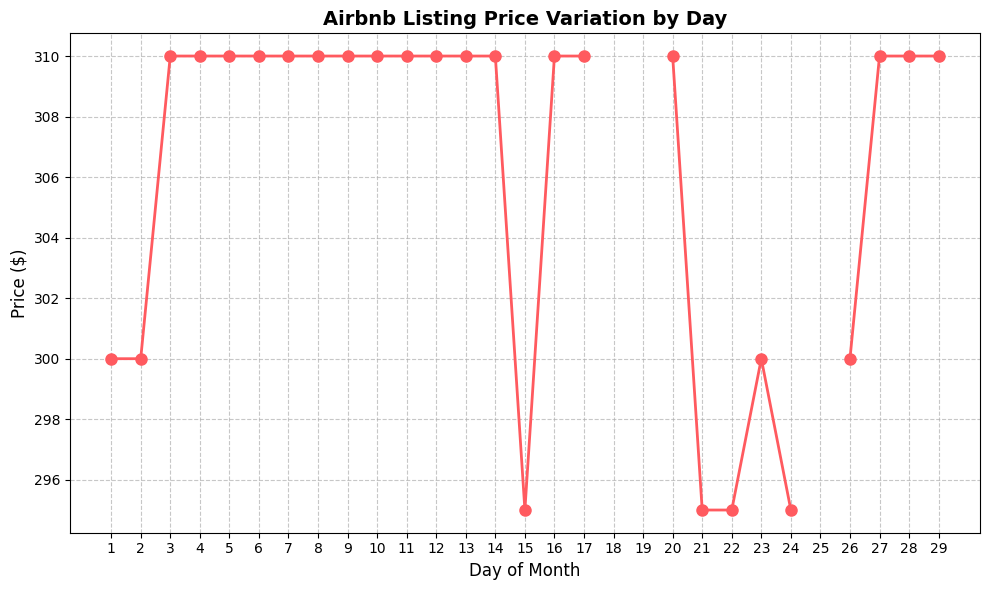

In [17]:

# Extract day from check_in_date for x-axis
days = list(df['check_in_date'].str[-2:].astype(int))

# Ensure prices are valid numbers, replacing None with a default value (e.g., 0)
prices = [float(price) if price != '' else None for price in df['price']]

days.sort()

# Create the plot with improved styling
plt.figure(figsize=(10, 6))
plt.plot(days, prices, marker='o', linestyle='-', linewidth=2, markersize=8, color='#FF5A5F')

# Add labels and title
plt.xlabel('Day of Month', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.title('Airbnb Listing Price Variation by Day', fontsize=14, fontweight='bold')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Format the x-axis to show all days
plt.xticks(days)

# Tight layout for better spacing
plt.tight_layout()